#### Visualize Dataset

In this notebook, we demonstrate the dataset structure.

In [2]:
import json
import pickle
import os
import pprint
import random
from collections import defaultdict
import numpy as np
from tqdm import tqdm
%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt
from IPython.display import IFrame

#### Load the dataset

In [7]:
with open("data/multi_label_train.json", "r") as fp:
    dataset = json.load(fp)

{'track_collision_in_medina/db3cb18197.jpg': {'url': 'https://i.pinimg.com/736x/a1/9d/57/a19d57d78bb9f51aeb8ecf790442c9bc--toy-trains-model-train.jpg',
  'incidents': {'truck accident': 0, 'train accident': 0},
  'places': {}},
 'flood_in_river/5e20892b3a.jpg': {'url': 'http://www.fayollemarine.eu/medias/album/276.jpg',
  'incidents': {'flooded': 1},
  'places': {'river': 1, 'building outdoor': 0}},
 'tornado_in_forest/00158.jpg': {'url': 'https://st4.depositphotos.com/18521618/20480/i/1600/depositphotos_204808880-stock-photo-landscape-hurricane-tornado-forest-scary.jpg',
  'incidents': {'under construction': 0,
   'drought': 0,
   'damaged': 0,
   'burned': 0},
  'places': {}},
 'car_wreck_in_park/00535.jpg': {'url': 'https://patch.com/img/cdn/users/920494/2012/10/raw/903150c1cc4c35c36890578577d4ff8d.jpg',
  'incidents': {'car accident': 0, 'traffic jam': 1},
  'places': {'park': 0, 'parking lot': 0, 'highway': 1}},
 'drought_in_alley/9922b7cae0.jpg': {'url': 'https://cdn.vox-cdn.com/

#### Use a dataset key (image name) and print the corresponding data

In [4]:
for image_name in tqdm(dataset.keys()):
    print(image_name)
    pprint.pprint(dataset[image_name])
    break

  0%|          | 0/89038 [00:00<?, ?it/s]

track_collision_in_medina/db3cb18197.jpg
{'incidents': {'train accident': 0, 'truck accident': 0},
 'places': {},
 'url': 'https://i.pinimg.com/736x/a1/9d/57/a19d57d78bb9f51aeb8ecf790442c9bc--toy-trains-model-train.jpg'}


In [6]:
counters = {}
counters["incidents"] = {}
counters["incidents"]["class_positive"] = defaultdict(int)
counters["incidents"]["class_negative"] = defaultdict(int)
counters["places"] = {}
counters["places"]["class_positive"] = defaultdict(int)
counters["places"]["class_negative"] = defaultdict(int)
for image_name in tqdm(dataset.keys()):
    url = dataset[image_name]["url"]
    for domain in ["incidents", "places"]:
        for category, label in dataset[image_name][domain].items():
            if label == 1:
                counters[domain]["class_positive"][category] += 1
            elif label == 0:
                counters[domain]["class_negative"][category] += 1

100%|██████████| 89038/89038 [00:00<00:00, 831681.50it/s]


In [8]:
def plot_graph_from_counter(counter):
    categories = list(counter["class_positive"].keys())
    class_positives = [counter["class_positive"][category] for category in categories]
    class_positives, categories = zip(*sorted(zip(class_positives, categories), reverse=True))
    class_negatives = [counter["class_negative"][category] for category in categories]

    ind = np.arange(len(categories))  # the x locations for the groups
    width = 0.4 # the width of the bars

    plt.figure(figsize=(80,40))
    plt.rcParams.update({'font.size': 50})
    plt.ylabel('Number of images', fontsize=100, labelpad=20)
    plt.bar(ind-0.2, class_positives, width=width, align='center')
    plt.bar(ind+0.2, class_negatives, width=width, align='center')
    plt.xticks(ind, list(categories), rotation=45, ha="right")
    plt.yticks(fontsize=100)
    plt.show()

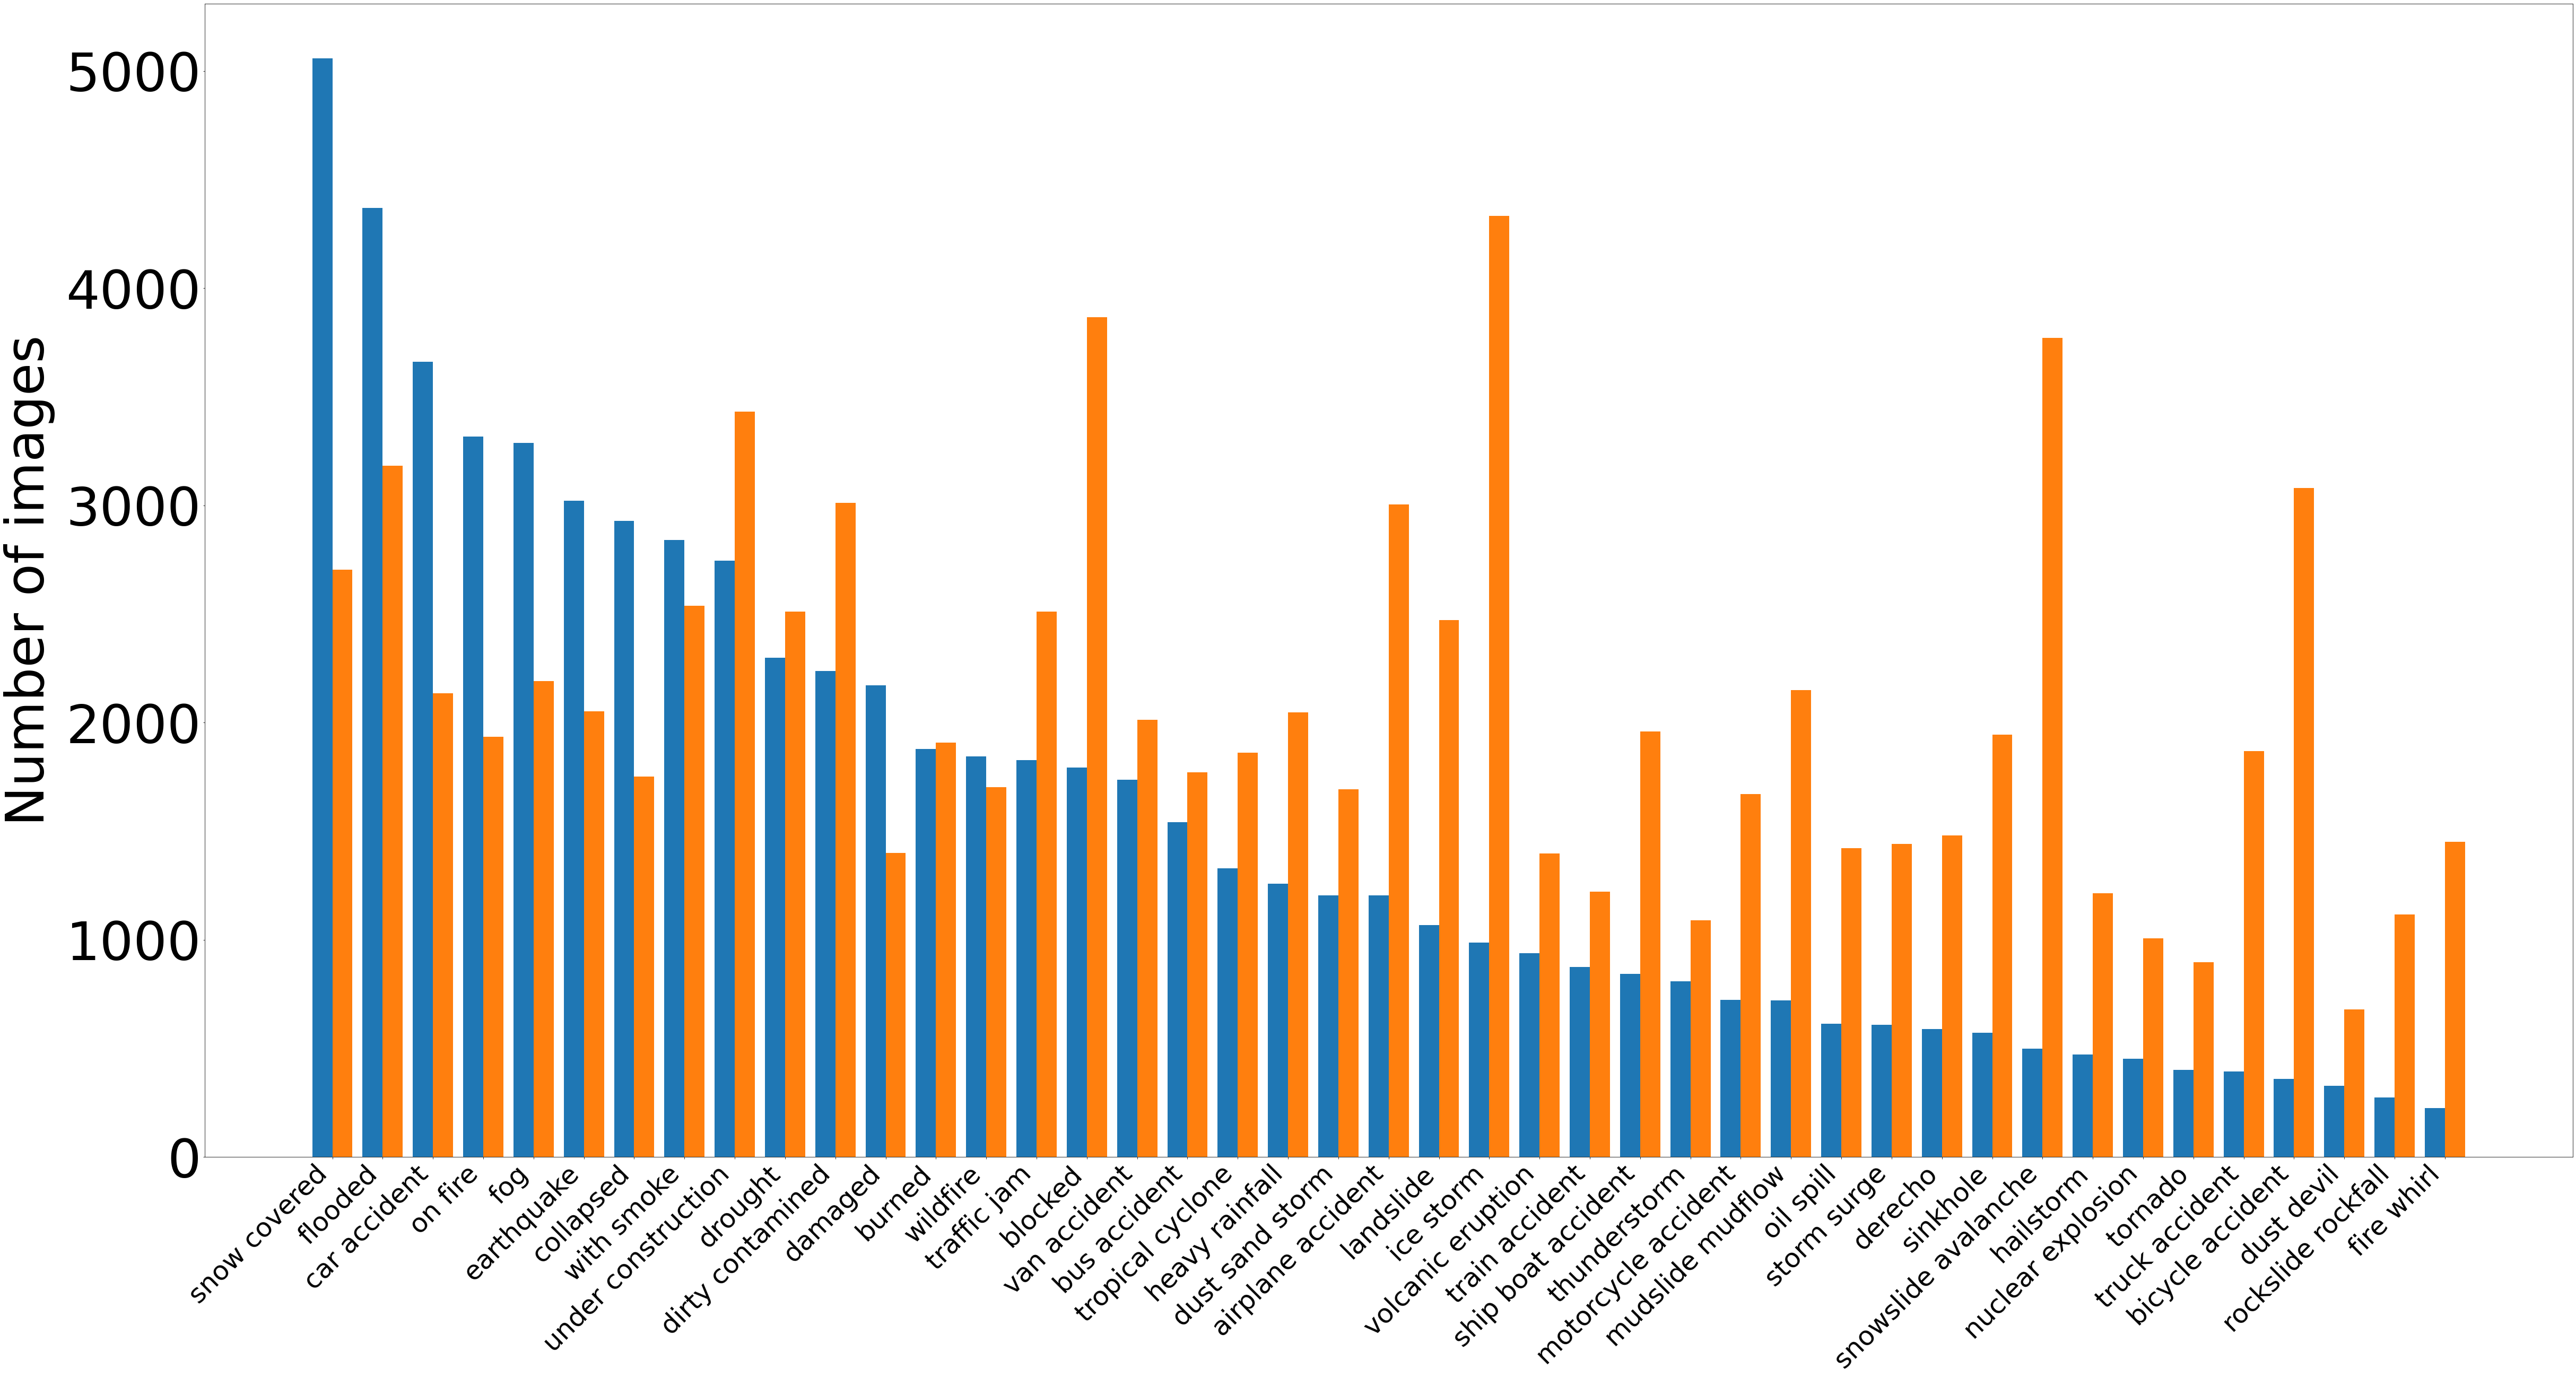

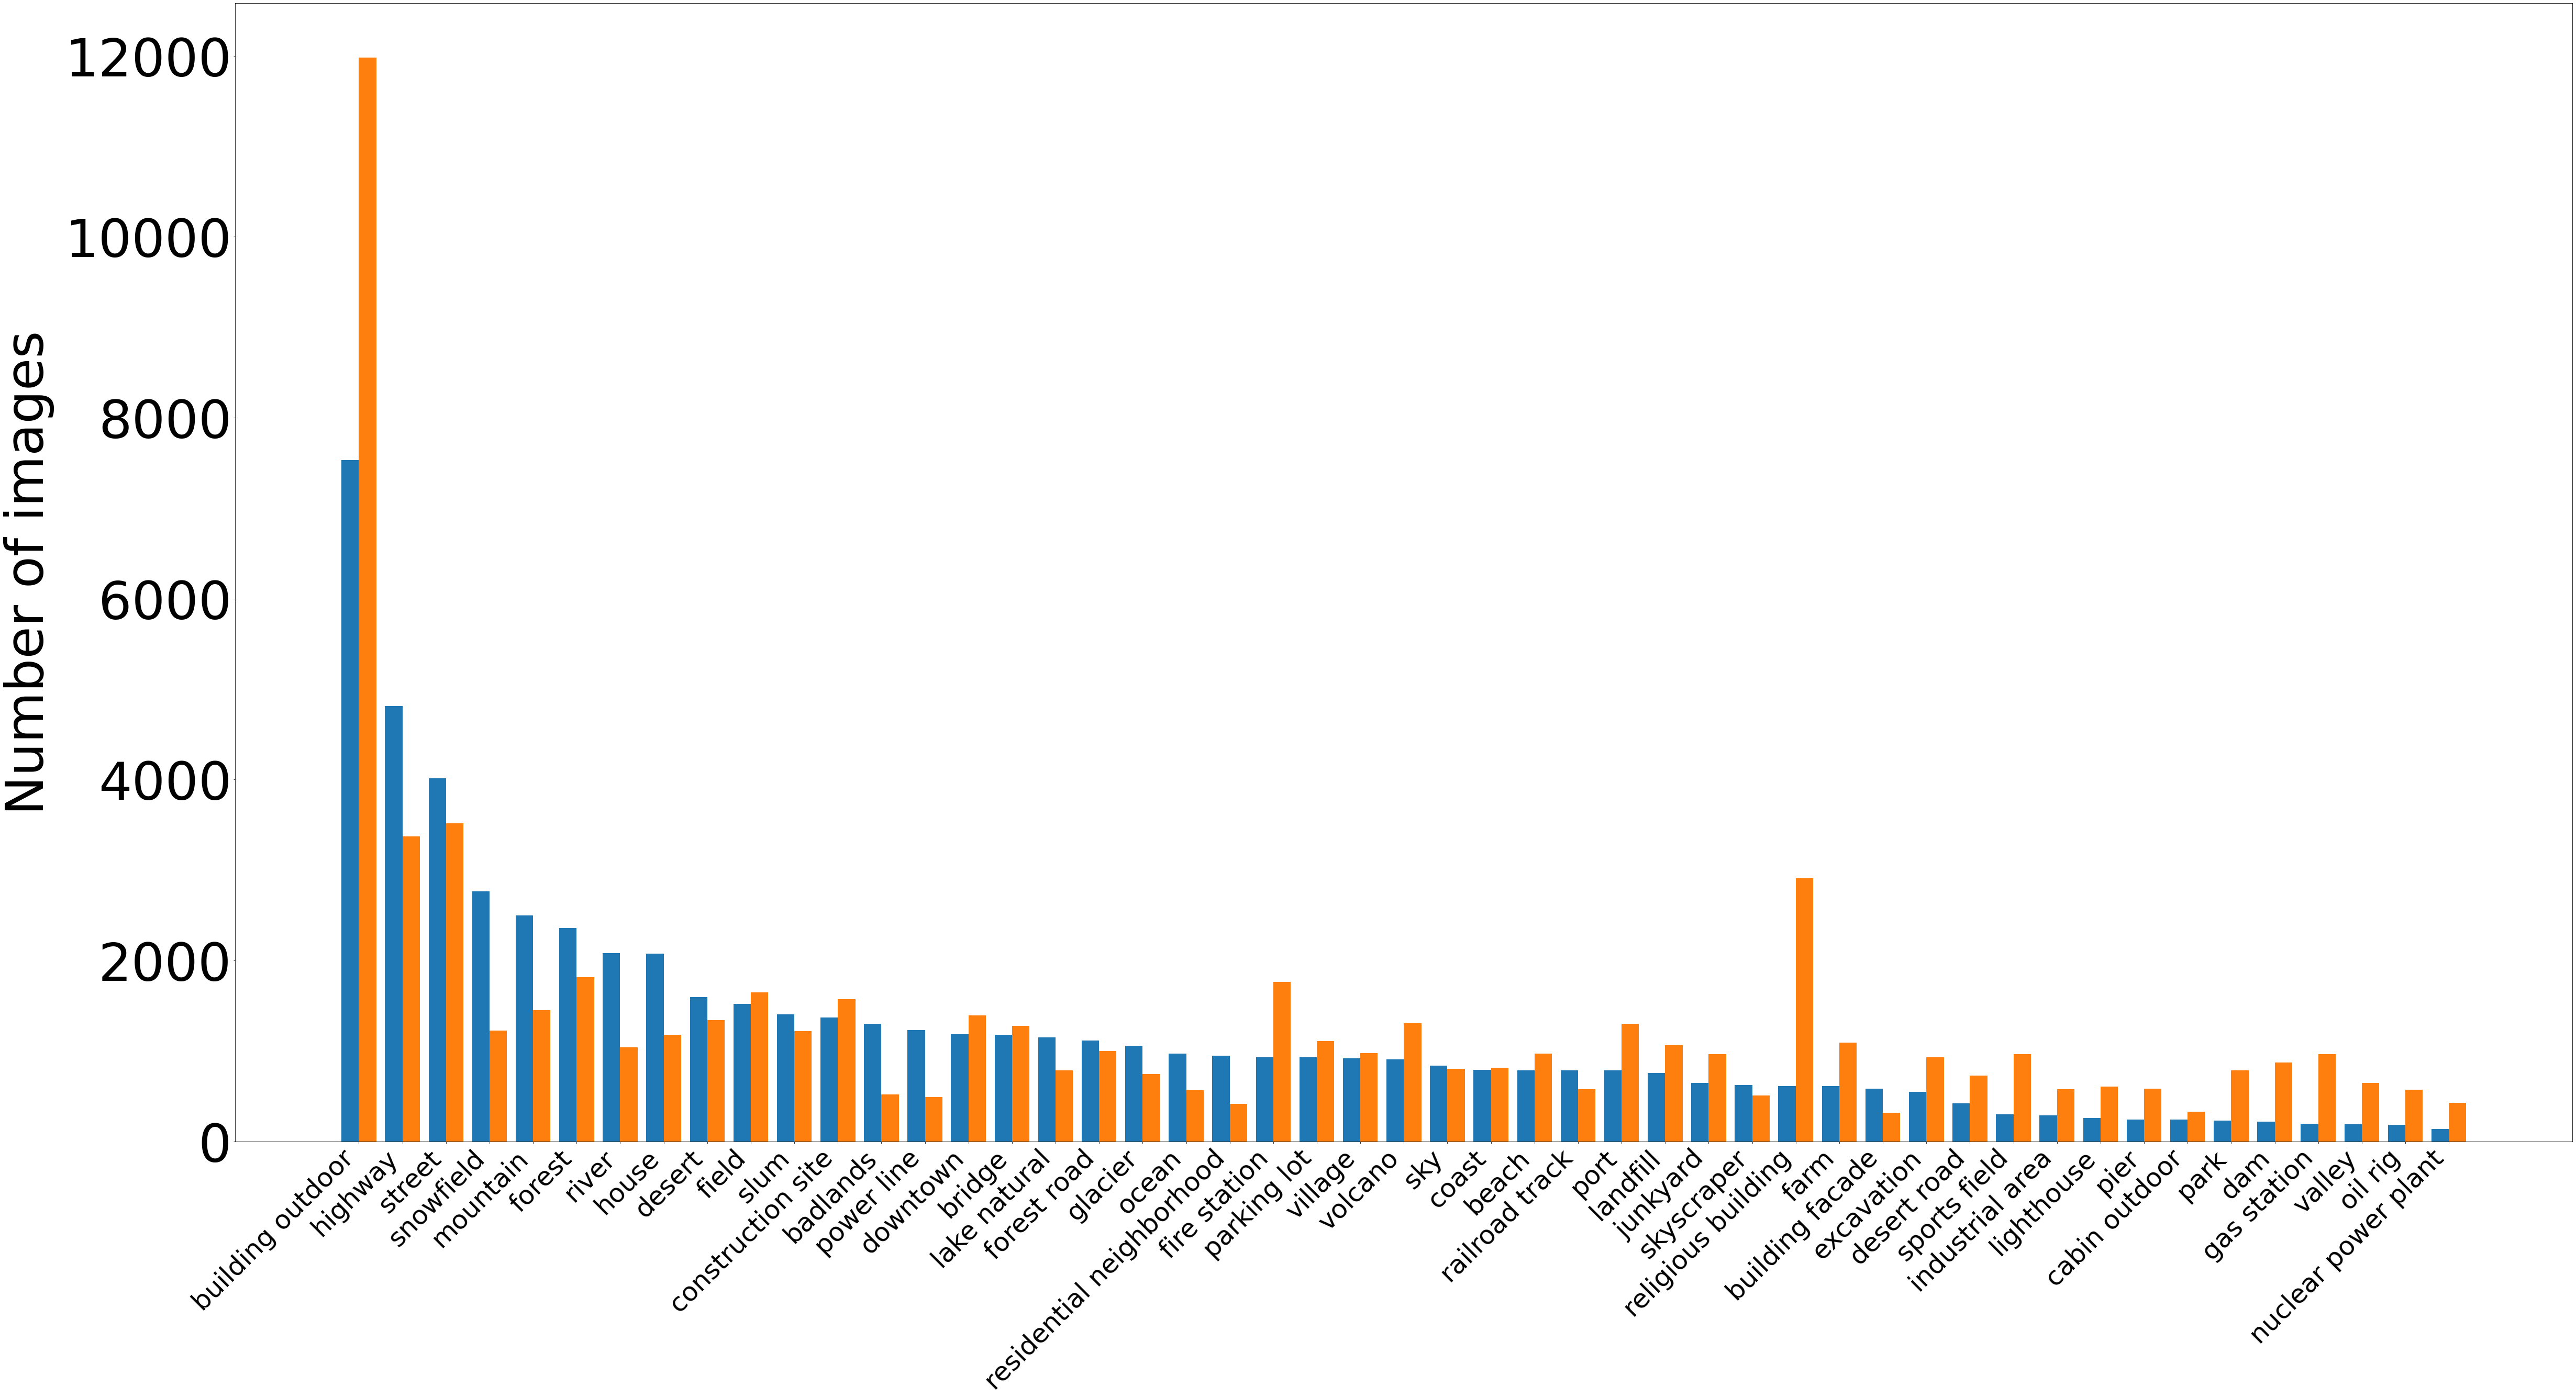

In [9]:
# uncomment to show the graphs
plot_graph_from_counter(counters["incidents"])
plot_graph_from_counter(counters["places"])

#### Both incident and place occuring in the same image

In [10]:
# count where both an incident and place occur in the same image
both_categories_count = defaultdict(dict)
for image_name in tqdm(dataset.keys()):
    image_data = dataset[image_name]
    for incident, val1 in image_data["incidents"].items():
        for place, val2 in image_data["places"].items():
            if val1 == 1 and val2 == 1:
                if place not in both_categories_count[incident]:
                    both_categories_count[incident][place] = 0
                both_categories_count[incident][place] += 1

100%|██████████| 89038/89038 [00:00<00:00, 927032.94it/s]


In [11]:
incident_categories = sorted(list(counters["incidents"]["class_positive"].keys()))
place_categories = sorted(list(counters["places"]["class_positive"].keys()))

In [12]:
matrix = []
for disaster in incident_categories:
    row = []
    for place in place_categories:
        try:
            row.append(both_categories_count[disaster][place])
        except:
            row.append(0)
    matrix.append(row)
matrix = np.array(matrix)

In [13]:
from mpl_toolkits.axes_grid1 import make_axes_locatable, axes_size
from matplotlib.colors import LogNorm
from matplotlib import ticker

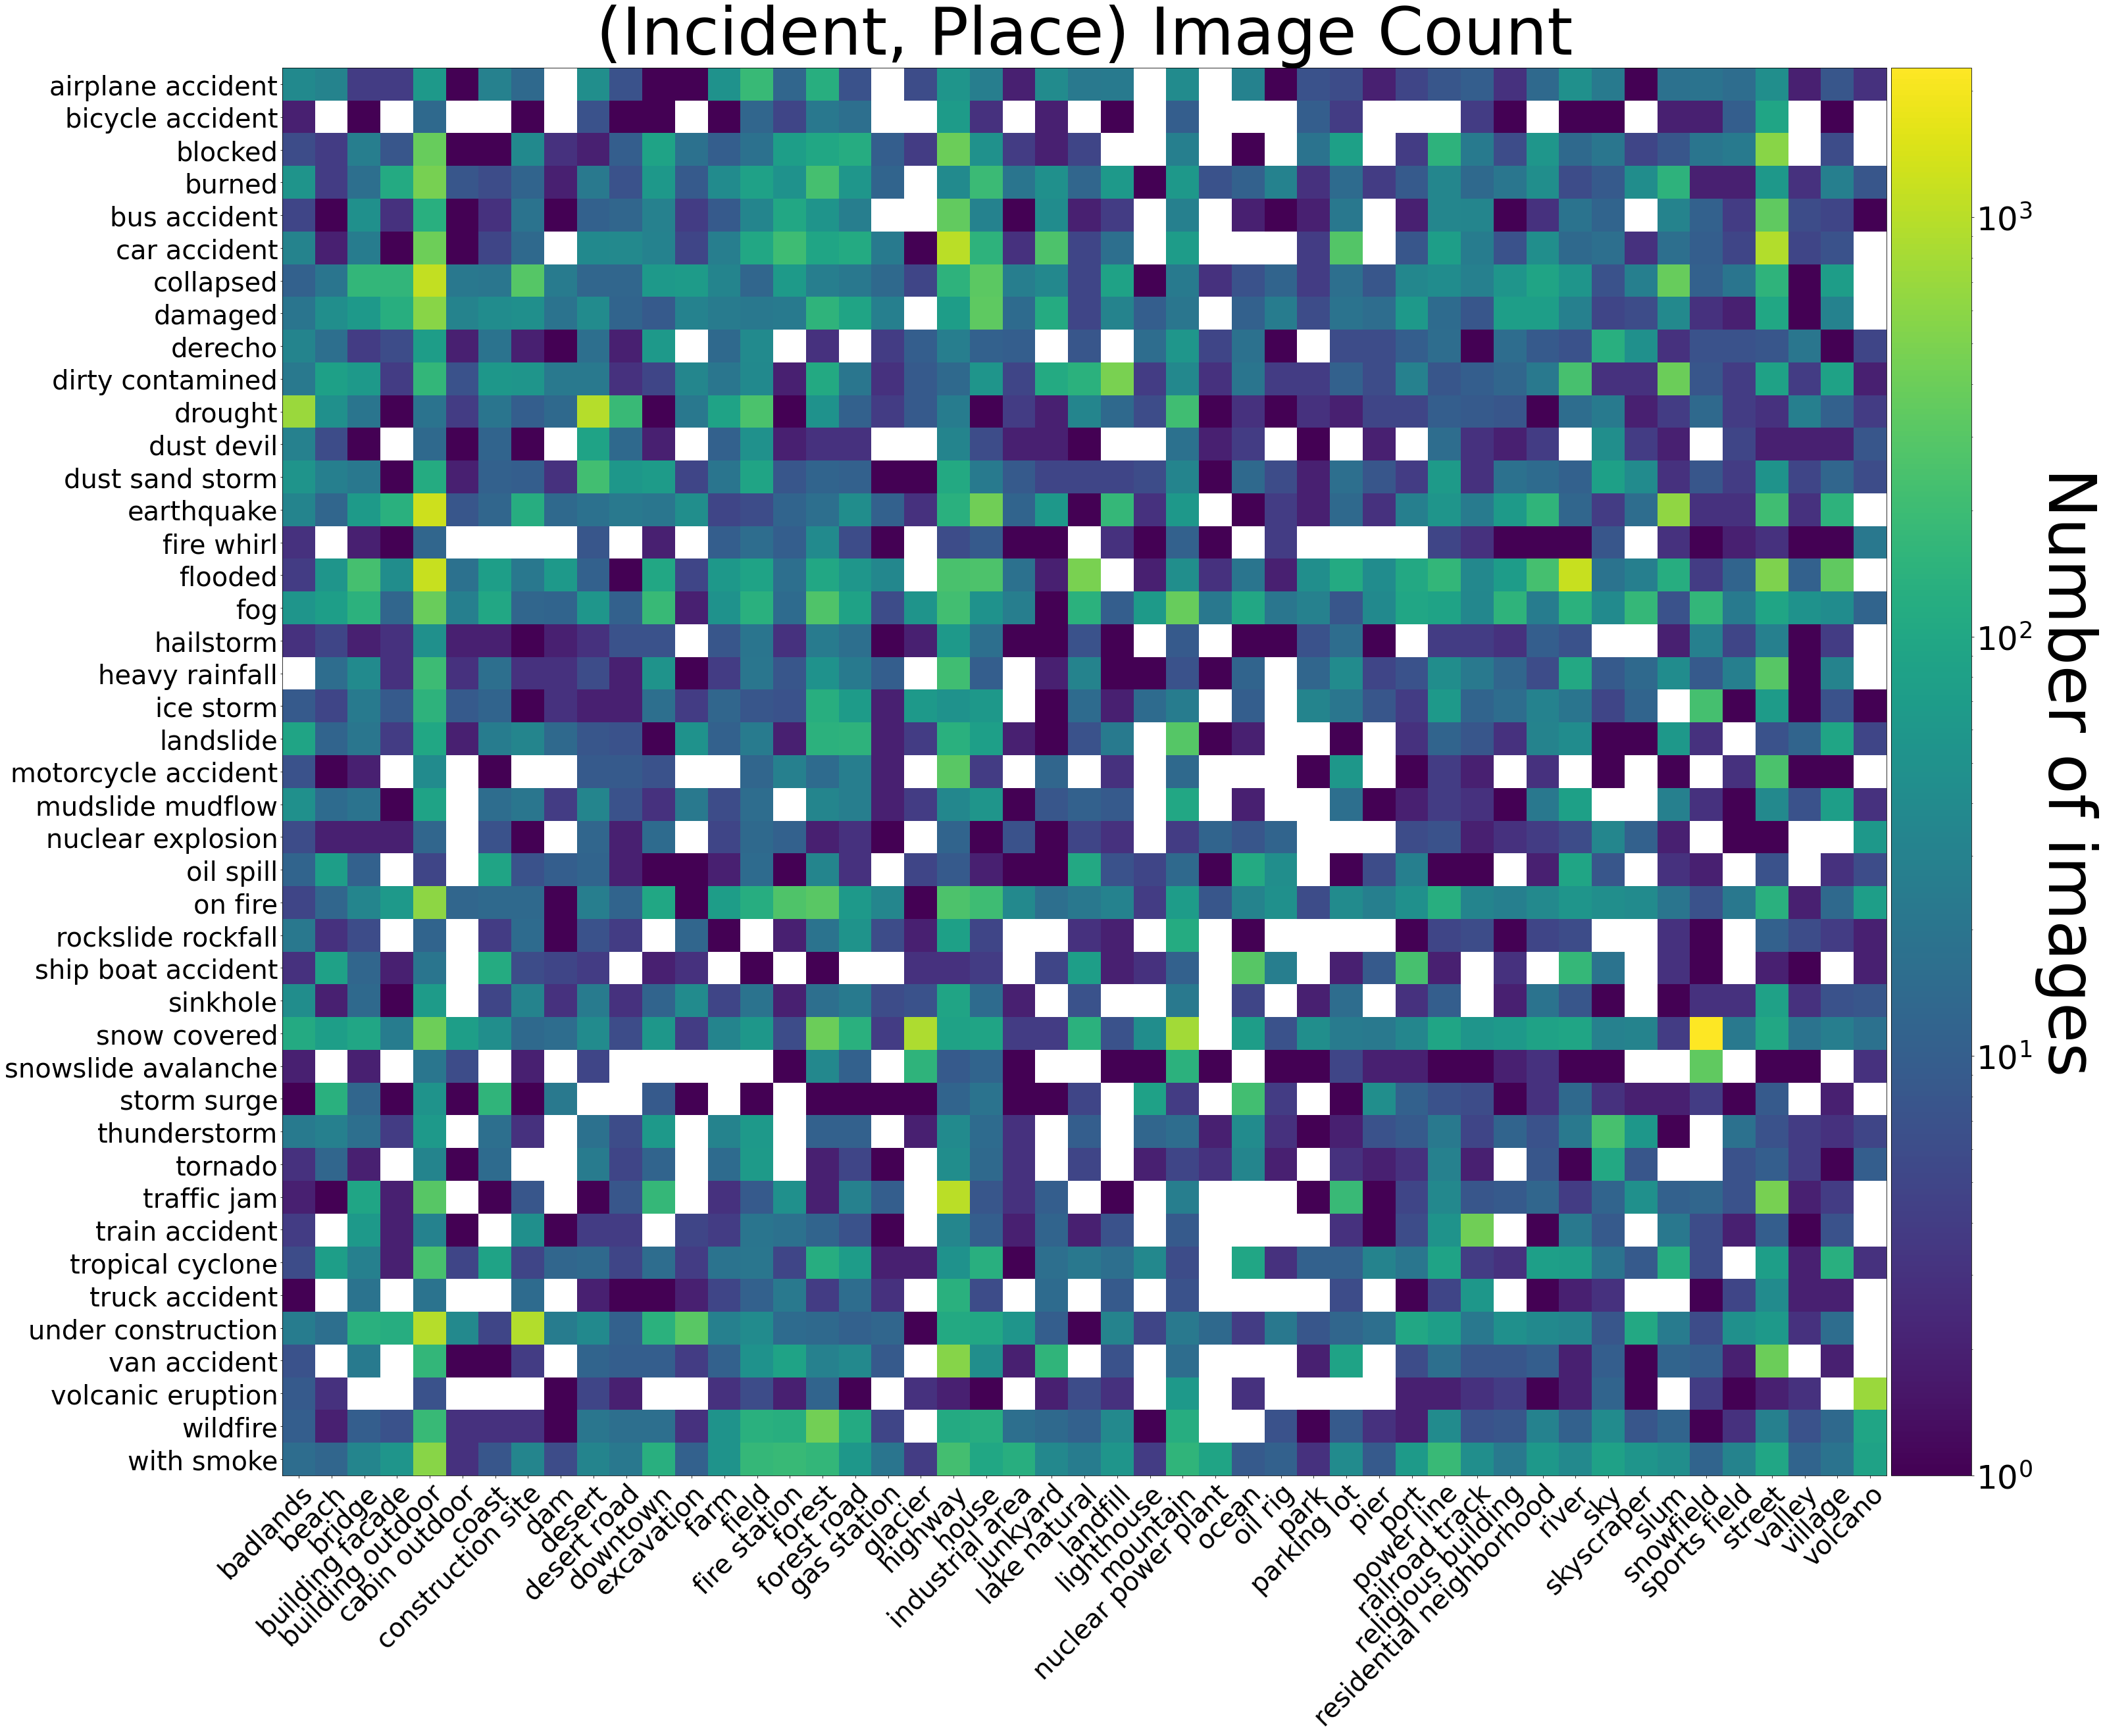

In [14]:
def show_incident_place_matrix():
    # https://matplotlib.org/devdocs/gallery/images_contours_and_fields/image_annotated_heatmap.html#sphx-glr-gallery-images-contours-and-fields-image-annotated-heatmap-py
    fig, ax = plt.subplots(figsize=(46, 40))
    im = ax.imshow(matrix, norm=LogNorm())

    fontsize = 40

    divider = make_axes_locatable(ax)
    cax = divider.append_axes("right", size="5%", pad=0.10)
    cbar = ax.figure.colorbar(im, cax=cax)

    cbar.ax.tick_params(labelsize=50)
    cbar.ax.set_ylabel("Number of images", rotation=-90, fontsize=100, labelpad=100)

    # We want to show all ticks...
    ax.set_xticks(np.arange(len(place_categories)))
    ax.set_yticks(np.arange(len(incident_categories)))
    # ... and label them with the respective list entries
    ax.set_xticklabels(place_categories, fontsize=fontsize)
    ax.set_yticklabels(incident_categories, fontsize=fontsize)

    # Rotate the tick labels and set their alignment.
    plt.setp(ax.get_xticklabels(), rotation=45, ha="right", rotation_mode="anchor")

    ax.set_title("(Incident, Place) Image Count", fontsize=100)
    plt.show()

# uncomment to show the 2d histogram (i.e., matrix)
show_incident_place_matrix()

#### Multi-label stats: number of images with (class positive) multi-labels

In [15]:
# how many have more than 1 incident
count = 0
num_pos_per_image = defaultdict(int)
pairs_histogram = defaultdict(list)
for image_name in tqdm(dataset.keys()):
    image_data = dataset[image_name]
    url = [image_data["url"]]
    incidents = list(image_data["incidents"].keys())
    num_incidents = 0
    for i in range(len(incidents)):
        if image_data["incidents"][incidents[i]] != 1:
            continue
        num_incidents += 1
        for j in range(i+1, len(incidents)):
            if image_data["incidents"][incidents[j]] != 1:
                continue
            key = tuple(sorted([incidents[i], incidents[j]]))
            pairs_histogram[key] += url
    
    for key, val in image_data["incidents"].items():
        for key2, val2 in image_data["incidents"].items():
            if val > 0 and val2 > 0:
                keyy = tuple(sorted([key, key2]))
                pairs_histogram[keyy] += url
            
    if num_incidents > 1:
        count += 1
    num_pos_per_image[num_incidents] += 1

100%|██████████| 89038/89038 [00:00<00:00, 492333.83it/s]


In [16]:
print("num images with > 1 incident: {}".format(count))
print("% of images in dataset with > 1 incident: {}".format(100.0 * (count / len(dataset))))
# note that for the ECCV datasets this % is trivial; we duplicate the images at train time to maintain the single-label assumption

num images with > 1 incident: 14154
% of images in dataset with > 1 incident: 15.89658348121027


In [17]:
import matplotlib as mpl
mpl.rcParams.update(mpl.rcParamsDefault)

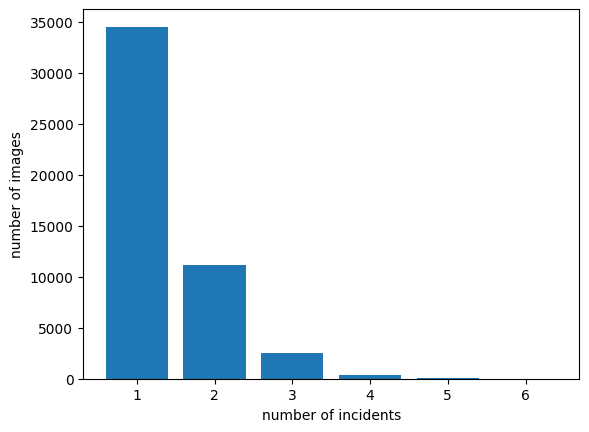

In [18]:
def show_plot():
    plt.xlabel('number of incidents')
    plt.ylabel('number of images')
    keys = list(sorted(num_pos_per_image.keys()))[1:]
    plt.bar(keys, [num_pos_per_image[key] for key in keys])
    plt.show()
# uncomment to show
show_plot()

#### Multi-label stats: incidents appearing together

In [19]:
matrix = []
for incident1 in incident_categories:
    row = []
    for incident2 in incident_categories:
        try:
#             if incident1 == incident2:
#                 row.append(0)
#                 continue
            key = tuple(sorted([incident1, incident2]))
            row.append(len(pairs_histogram[key]))
        except:
            row.append(0)
    matrix.append(row)
matrix = np.array(matrix)

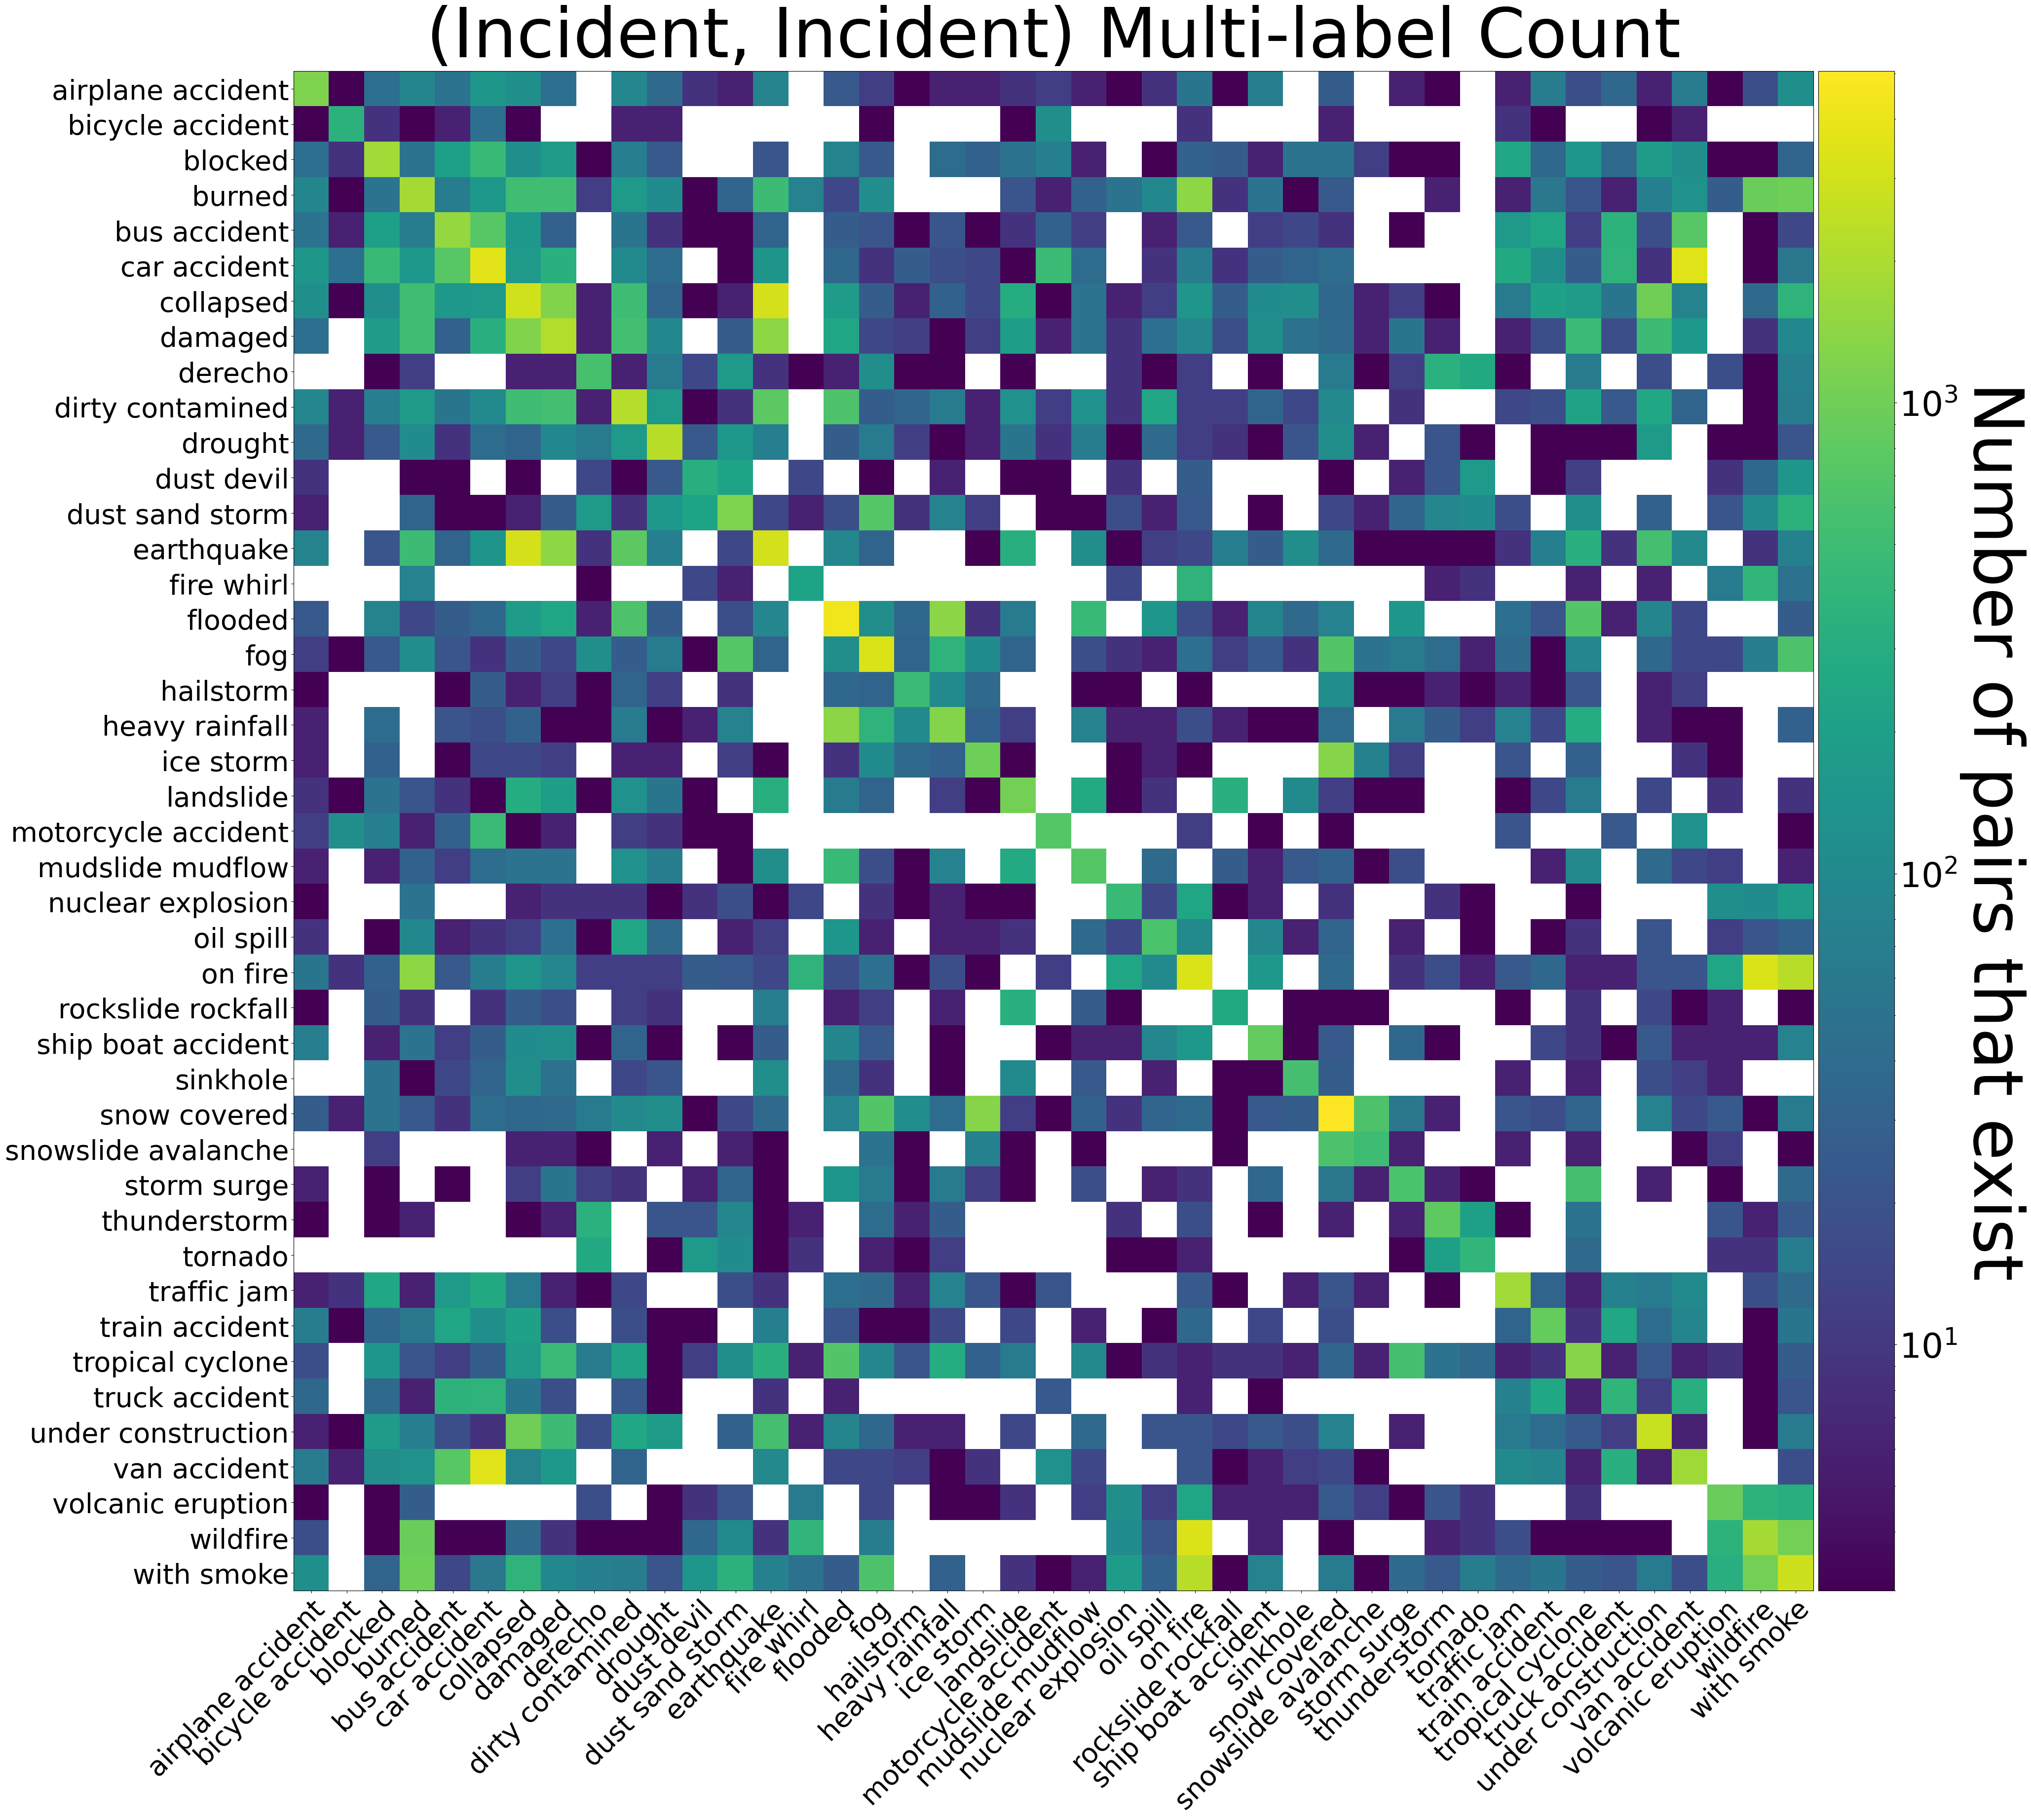

In [20]:
def show_multi_plot():
    # https://matplotlib.org/devdocs/gallery/images_contours_and_fields/image_annotated_heatmap.html#sphx-glr-gallery-images-contours-and-fields-image-annotated-heatmap-py
    fig, ax = plt.subplots(figsize=(46, 40))
    im = ax.imshow(matrix, norm=LogNorm())

    fontsize = 40

    divider = make_axes_locatable(ax)
    cax = divider.append_axes("right", size="5%", pad=0.10)
    cbar = ax.figure.colorbar(im, cax=cax)

    cbar.ax.tick_params(labelsize=50)
    cbar.ax.set_ylabel("Number of pairs that exist", rotation=-90, fontsize=100, labelpad=100)

    # We want to show all ticks...
    ax.set_xticks(np.arange(len(incident_categories)))
    ax.set_yticks(np.arange(len(incident_categories)))
    # ... and label them with the respective list entries
    ax.set_xticklabels(incident_categories, fontsize=fontsize)
    ax.set_yticklabels(incident_categories, fontsize=fontsize)

    # Rotate the tick labels and set their alignment.
    plt.setp(ax.get_xticklabels(), rotation=45, ha="right", rotation_mode="anchor")

    ax.set_title("(Incident, Incident) Multi-label Count", fontsize=100)
    plt.show()

# uncomment to show
show_multi_plot()

#### Show images

In [21]:
def get_urls(incident, place, num_images=50):
    """If incident and/or place are None, don't filter.
    """
    urls = []
    for image_name in tqdm(dataset.keys()):
        image_data = dataset[image_name]
        try:
            if incident is None or image_data["incidents"][incident] == 1:
                if place is None or image_data["places"][place] == 1:
                    url = image_data["url"]
                    urls.append(url)
        except:
            pass
    return random.sample(urls, min(len(urls), num_images))

In [23]:
incident = "flooded"
place = "parking lot"
urls = get_urls(incident, place)

html_str = """"""
for url in urls:
    html_str += """<img src="{}" height="100px" width="100px">""".format(url)
html_file = open("temp.html", "w")
html_file.write(html_str)
html_file.close()

# uncomment to visualize images
IFrame(src='temp.html', width=1000, height=400)

100%|██████████| 89038/89038 [00:00<00:00, 1989369.71it/s]
